# Smart Meters in London: Data Cleaning (Part 1/2)

There are three main objectives in this project, as stated below:

1. Create a ML algorithm to forecast the electricity consumption for one household considering the prior smart meter data we have. Hence, we could create a Dashboard with Tableau to show the results that end-user has. 

2. Classifying our portfolio clients according to their consumption, but also according to acorn classification. 

3. Analyse the influence of the weather into our energy consumption. This last step could be performed in two ways: considering only one household, or, on the contrary, aggregating all the demand we have in our 6000 clients. 

This first jupyter notebook wants to analyse the data that has been retrieved from Kaggle, London Data Store and Accorn CICA Company. There are three main files to analyse and clean for this project: 

- **information_households.csv**
- **weather_hourly_darksky.csv**
- **hhblock_dataset.zip : Block_12**
- **halfhourly_dataset.zip: Block_12** 

The structure of this notebook is as follows:

1. Dataset overview
2. Data Cleaning: Missing values 
3. Data Cleaning: Outliers 
4. Date Time columns transformation 
5. Exporting tables to GoogleCloud and SQL

In [1]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os

In [2]:
# Taking a look which is our current working directory. 
os.getcwd()

'/home/ingrid/Documents/SENSE_2019/SENSE_Workshop_2019'

## 1. Importing data

#### 1.1. Households clients information

In [5]:
# Importing information_households csv to see their contracts and their ID.
info_households = pd.read_csv('0.Data/raw_data/informations_households.csv')

In [6]:
# Printing the head of the df to see how this dataset looks like. 
info_households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


Each row in this dataset contains: 
- LCLid: user ID
- stdorToU: Type of tariff this user has 
- Acorn: acorn category this end-user belongs to 
- Acorn_grouped: group where this end-user belongs to, subgroup
- file: csv block file where the electricity consumption from this end-user can be found. 

In [53]:
# Checking the types of this df. 
info_households.dtypes

LCLid            object
stdorToU         object
Acorn            object
Acorn_grouped    object
file             object
dtype: object

We can see from the cell above, that this df only contains string information about the characteristics of the end-user. Hence, everything will be considered as `object`

In [54]:
# Cheking how many rows and columns we have in our dataset. 
info_households.shape

(5566, 5)

In [68]:
# counting how many repeated clients we have
(info_households['LCLid'].value_counts() != 1).sum()

0

As we can see from the cell above, there are no repeated IDs for the end users. We have 5566 rows and 5566 unique values, one for each user. 
Hence, we can directly save this df into the SQL Database. 

In [56]:
# Saving the dataframe into a csv file into our cleaned_data folder
info_households.to_csv('../0.Data/clean_data/info_households_cleaned.csv')

Later on, we will work with the data about the user MAC000291. For this reason, in the cell below we take a rapid look on the information about this end-user. 

In [19]:
# Filtering the dataset for the end-user with LCLid = MAC000291
info_househoulds[info_househoulds['LCLid']=='MAC000291']

,LCLid,stdorToU,Acorn,Acorn_grouped,file
623,MAC000291,Std,ACORN-D,Affluent,block_12


The client that we want to study in this case is one user with ID = **MAC000291**, who has a **Standard** tariff and also is considered under ACORN D group. 

#### 1.2 Weather hourly data
One of the three objectives we have is to analyse whether the electricity consumption is influenced by the weather conditions. 

In [20]:
# Reading the csv file
weather_hourly = pd.read_csv('../0.Data/raw_data/weather_hourly_darksky.csv')

In [21]:
weather_hourly.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [22]:
# Checking the types of each feature in this dataframe. 
weather_hourly.dtypes

visibility             float64
windBearing              int64
temperature            float64
time                    object
dewPoint               float64
pressure               float64
apparentTemperature    float64
windSpeed              float64
precipType              object
icon                    object
humidity               float64
summary                 object
dtype: object

We need to change the column Time, since it is considered as an object right now. 

In [23]:
# Changing the column time from object type into datetime. 
weather_hourly.time = pd.to_datetime(weather_hourly.time)

In [24]:
# Checking again the types to see whether they are correct or not. 
weather_hourly.dtypes

visibility                    float64
windBearing                     int64
temperature                   float64
time                   datetime64[ns]
dewPoint                      float64
pressure                      float64
apparentTemperature           float64
windSpeed                     float64
precipType                     object
icon                           object
humidity                      float64
summary                        object
dtype: object

In [25]:
# Checking how many null values we have in our dataframe. 
weather_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
visibility             21165 non-null float64
windBearing            21165 non-null int64
temperature            21165 non-null float64
time                   21165 non-null datetime64[ns]
dewPoint               21165 non-null float64
pressure               21152 non-null float64
apparentTemperature    21165 non-null float64
windSpeed              21165 non-null float64
precipType             21165 non-null object
icon                   21165 non-null object
humidity               21165 non-null float64
summary                21165 non-null object
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


As we can see from the cell above, we don't have missing values in the weather hourly information dataframe. Hence, we can export this table to SQL directly as it is.

In [26]:
weather_hourly.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [27]:
# We need to sort the values by time period, in order to be able to plot a time-series analysis 
weather_hourly = weather_hourly.sort_values(by = 'time')

In [28]:
# Reseting the index to have it sorted by timeperiod 
weather_hourly.reset_index(inplace=True)

In [29]:
# Printing the head to see the df corrected
weather_hourly.head()

,index,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,312,13.63,160,13.49,2011-11-01 00:00:00,11.48,1008.14,13.49,3.11,rain,clear-night,0.88,Clear
1,313,13.26,154,12.73,2011-11-01 01:00:00,11.58,1007.88,12.73,3.08,rain,partly-cloudy-night,0.93,Partly Cloudy
2,314,12.94,161,13.65,2011-11-01 02:00:00,12.14,1007.09,13.65,3.71,rain,clear-night,0.91,Clear
3,315,12.99,170,14.13,2011-11-01 03:00:00,12.24,1006.50,14.13,3.95,rain,partly-cloudy-night,0.88,Partly Cloudy
4,316,12.92,180,14.17,2011-11-01 04:00:00,12.59,1006.14,14.17,3.97,rain,partly-cloudy-night,0.90,Partly Cloudy


In [260]:
# Saving the cleaned csv file into our data folder. 
weather_hourly.to_csv('../0.Data/clean_data/weather_hourly_cleaned.csv')

#### 1.3 hh block 12 importing. 

When dealing with time series, there are different ways to analyse them. In this case, from the data we have retrieved, there are different ways of visualizing the same data. 

In this case `hh_block12` has the information structured as features for each half-hour on that day. 

In [31]:
# Reading the csv file 
hh_block12 = pd.read_csv('../0.Data/raw_data/hhblock_dataset/block_12.csv')

In [32]:
# Taking a look at the head of the dataframe. 
hh_block12.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000291,2012-03-03,0.187,0.193,0.177,0.197,0.178,0.181,0.192,0.175,...,1.045,1.053,1.003,0.991,0.967,0.643,0.556,0.433,0.361,0.300
1,MAC000291,2012-03-04,0.293,0.269,0.287,0.268,0.275,0.273,0.264,0.284,...,0.367,0.373,0.360,0.387,0.362,0.886,0.899,0.962,0.900,0.709
2,MAC000291,2012-03-05,0.271,0.246,0.270,0.245,0.263,0.267,0.371,0.270,...,0.430,0.436,0.422,0.570,0.933,0.899,0.667,0.669,0.647,0.465
3,MAC000291,2012-03-06,0.242,0.248,0.225,0.255,0.227,0.244,0.232,0.229,...,1.131,0.970,0.948,0.641,0.506,0.583,0.620,0.514,0.300,0.241
4,MAC000291,2012-03-07,0.250,0.228,0.233,0.251,0.262,0.255,0.252,0.255,...,1.059,1.217,1.214,0.960,0.666,0.610,0.491,0.453,0.306,0.247


In [33]:
# Checking the shape of the dataframe. 
hh_block12.shape

(32931, 50)

#### 1.4 Half hourly block 12 (Different format than above)

In this case, and for being able to plot time-series, it is normally preferred to have one line for timestamp. This is how this datase `halfhourly_dataset` is structured. In this section, this dataset is imported and the data exploration will be performed. 

In [72]:
# Reading the csv file. 
halfhourly_block12 = pd.read_csv('../0.Data/raw_data/halfhourly_dataset/block_12.csv')

In [73]:
# Taking a look at the head of the dataframe. 
halfhourly_block12.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000291,2012-03-02 09:30:00.0000000,1.158
1,MAC000291,2012-03-02 10:00:00.0000000,1.499
2,MAC000291,2012-03-02 10:30:00.0000000,1.433
3,MAC000291,2012-03-02 11:00:00.0000000,0.51
4,MAC000291,2012-03-02 11:30:00.0000000,0.455


In [74]:
# Checking the types of the df. 
halfhourly_block12.dtypes

LCLid             object
tstp              object
energy(kWh/hh)    object
dtype: object

`LCLid` has to be considered as an object. However, the feature `tstp`, that is a timestamp, should be transformed into a datetime object. Also, the column `energy` should be transformed into float. However, in order to make the procedure more understandable, we will change the name of these columns to a better one. 

In [75]:
# Checking the current name of the columns 
halfhourly_block12.columns

Index(['LCLid', 'tstp', 'energy(kWh/hh)'], dtype='object')

In [76]:
# Changing the name of the columns. 
halfhourly_block12.columns = ['LCLid', 'DateTime', 'kWh/hh']

In [77]:
# Transforming the column Energy into float
halfhourly_block12['kWh/hh'] = pd.to_numeric(halfhourly_block12['kWh/hh'], errors='coerce')

Now we can check how many null values we have in our dataframe

In [78]:
# Counting how many null values we have.
halfhourly_block12.isna().sum()

LCLid        0
DateTime     0
kWh/hh      50
dtype: int64

As we can see from the cell above, we have 50 missing values that have to be either removed or filled in. 

In the cell below, we can see which are the rows that currently calculate the amount of data that we would lose if we remove these NaN values. Furthermore, we can see where these missing values take place. 

In [81]:
# Checking where these NaN values take place. 
halfhourly_block12[halfhourly_block12['kWh/hh'].isna()].head(10)

,LCLid,DateTime,kWh/hh
13979,MAC000291,2012-12-18 15:15:05.0000000,NaN
46984,MAC000551,2012-12-18 15:16:06.0000000,NaN
79987,MAC000572,2012-12-18 15:16:08.0000000,NaN
112221,MAC000803,2012-12-18 15:17:08.0000000,NaN
143162,MAC001495,2012-12-18 15:19:46.0000000,NaN
173429,MAC001787,2012-12-18 15:20:53.0000000,NaN
203628,MAC001800,2012-12-18 15:20:55.0000000,NaN
233850,MAC001821,2012-12-18 15:20:58.0000000,NaN
263583,MAC002137,2012-12-18 15:21:39.0000000,NaN
293277,MAC002144,2012-12-18 15:21:40.0000000,NaN


In [42]:
# Calculating how much data we lose if we would remove these NaNs. 
halfhourly_block12.iloc[[13979]]

,LCLid,DateTime,kWh/hh
13979,MAC000291,2012-12-18 15:15:05.0000000,NaN


In [43]:
halfhourly_block12.iloc[[13978]]

,LCLid,DateTime,kWh/hh
13978,MAC000291,2012-12-18 15:00:00.0000000,0.304


In [44]:
halfhourly_block12.iloc[[13980]]

,LCLid,DateTime,kWh/hh
13980,MAC000291,2012-12-18 15:30:00.0000000,0.25


The time period we are considering in this case is 30'. Then, according to what we see in the cells above, the cell that contains `NaN` are out of the time period considered here. Our timeperiods will be `15:00` and `15:30`. For this reason, we will drop them out. 

In [45]:
# Droping null values 
halfhourly_block12.dropna(inplace = True )

In [46]:
# Checking how many missing values we have after droping them out. 
halfhourly_block12.isna().sum()

LCLid       0
DateTime    0
kWh/hh      0
dtype: int64

In [47]:
halfhourly_block12.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00.0000000,1.158
1,MAC000291,2012-03-02 10:00:00.0000000,1.499
2,MAC000291,2012-03-02 10:30:00.0000000,1.433
3,MAC000291,2012-03-02 11:00:00.0000000,0.510
4,MAC000291,2012-03-02 11:30:00.0000000,0.455


We want to see the quantity of clients we have in Block_12 to have a clear idea of the amount of users for block.

In [64]:
print(f"Block_12 has {halfhourly_block12['LCLid'].value_counts().shape[0]} users")

Block_12 has 50 users


In [48]:
# Checking the types we have in our df 
halfhourly_block12.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

The next type to change is the DateTime object. 

In [49]:
# Changing the DateTime column into DateTime 
halfhourly_block12['DateTime'] = pd.to_datetime(halfhourly_block12['DateTime'], yearfirst=True)

In [50]:
# Checking the types we have in our df 
halfhourly_block12.dtypes

LCLid               object
DateTime    datetime64[ns]
kWh/hh             float64
dtype: object

Now the dataframe is ready to be saved into the database. 

In [283]:
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/your-project/2.JupyterNotebooks'

In [241]:
# Saving the cleaned data into a csv file into our clean_data folder.
halfhourly_block12.to_csv('../0.Data/clean_data/halfhourly_block12_cleaned.csv')

### Analysing the energy consumption of user with LCLId = MAC000291

Our first objective is to analyse the energy consumption from one end user to see what are the trends and the decomposition of this time-series variable. 

In [284]:
halfhourly_block12.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


We will create a new dataframe only for the information of the user with ID MAC000291

In [287]:
# Filtering our dataset with only the information of the user with ID MAC000291
MAC000291_df = halfhourly_block12[halfhourly_block12['LCLid']=='MAC000291']

In [288]:
# Printing to see how the head looks like 
MAC000291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


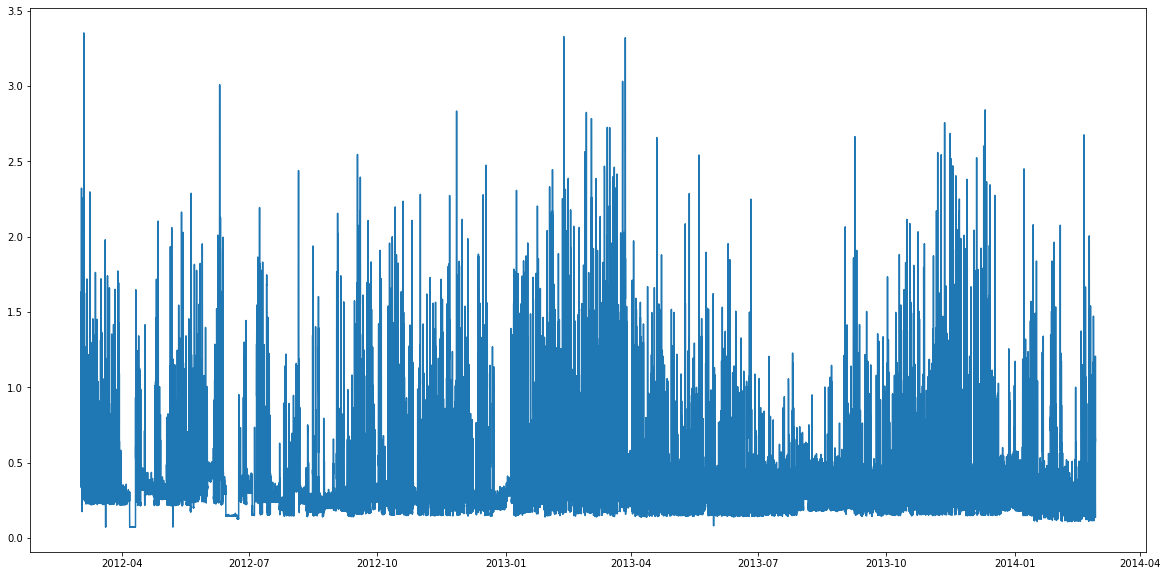

In [291]:
# Creating a figure to see how the time-series variable looks like
plt.figure(figsize=(20,10))
plt.plot(MAC000291_df['DateTime'], MAC000291_df['kWh/hh'])

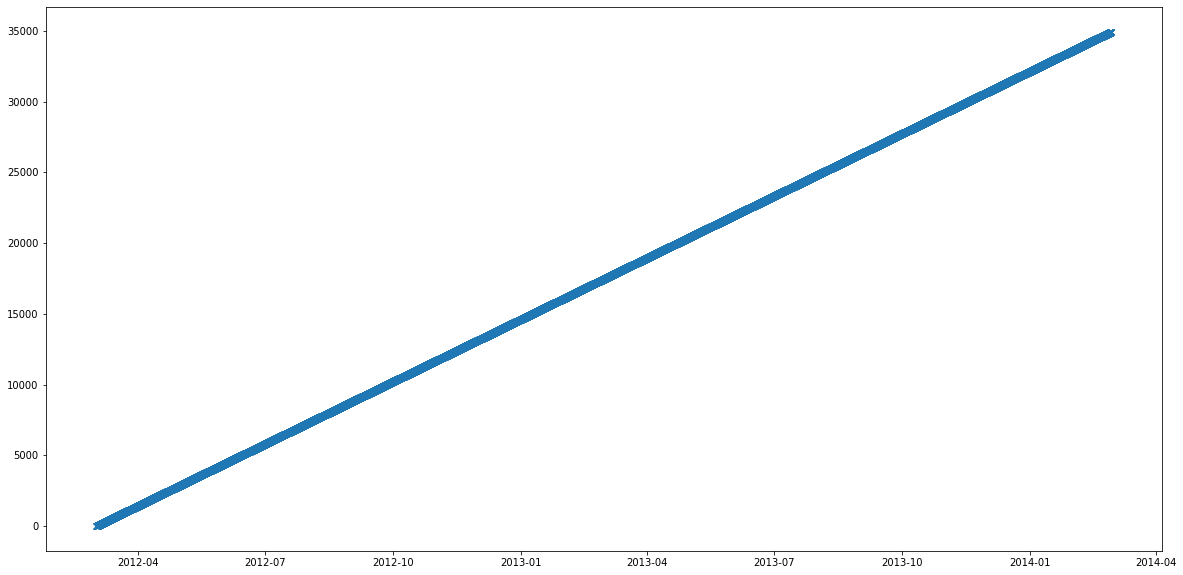

In [292]:
# Plotting to see that the evolution of the timestamp is linear and increasively, and that it is ordered. 
lt.figure(figsize=(20,10))
plt.plot(MAC000291_df['DateTime'], range(len(MAC000291_df)), 'x')

As we can see from the figure below, we don't have missing values and also the timestamp is ordered as it should be. Hence, the dataset can be saved in a csv file into cleaned_data folder.

In [261]:
# Setting the DateTime column as an index to see how much data we have on each year. 
halfhourly_block12.index = halfhourly_block12['DateTime']

In [198]:
# Calculating the amount of data we have in 2012.
halfhourly_block12['2012'].shape

(606993, 3)

In [199]:
# Calculating the amount of data we have in 2013
halfhourly_block12['2013'].shape

(856573, 3)

In [200]:
# Calculating the amount of data we have in 2014. 
halfhourly_block12['2014'].shape

(127621, 3)

 As well, by taking a look into the shape of each year, we can see that we have more or less the same amount of data for 2012 and 2013. In the case of 2014, since we are only considered 3 months of the year, we don't have the same amount of data, but proportionally is equal to the others. 

In [293]:
# Saving the information of the end-user MAC000291 Into a csv file. 
MAC000291_df.to_csv('../0.Data/clean_data/MAC000291_cleaned_consumption.csv')

## Exporting tables into the DB 

The last step to finish the first step of the Workflow regarding the Data Wrangling and Cleaning part is to export the cleaned dataframes into the centralized databased. In this case, the tables will be saved into a GoogleCloud SQL Database. For security reasons, the credentials of the database are not shown in this notebook. 

In [3]:
import Credentials_secrets as credentials

In [6]:
# Workbench Databench 
driver = credentials.driver
user = credentials.user
password = credentials.password
ip = credentials.ip
database = credentials.database

In [7]:
# connection_string to connect to Workbench Database 
connection_string = f'{driver}://{user}:{password}@{ip}/{database}'

In [10]:
# Engine creation 
engine = create_engine(connection_string)

In [61]:
# Uploading households_info dataset into mySQL Database 
info_households.to_sql('info_households', engine, index = False)

In [60]:
# Uploading weather hourly table into mySQL Database
weather_hourly.to_sql('weather_hourly', engine, index = False)

In [62]:
# Uploading information regarding halfhourly block 12 table into mySQL Database 
halfhourly_block12.to_sql('halfhour_block12', engine, index = False)